# Custom Cropping

Sometimes, it can happen that only a part of the tissue is usable for analysis, for example due to artifacts or poor tissue quality in a certain region. In such cases, it can make sense to mask out problematic regions. This way, the image can still be used for downstream analysis, but the artifact will not influence results in a negative way. `Spatialproteomics` allows users to upload a binary mask, which indicates which part of the image is suitable for further analysis and which part is not.

The example below shows how one could for example use [TissueTag](https://github.com/Teichlab/TissueTag/tree/main) to obtain such a mask, load it into the spatialproteomics and use the mask to remove the artifact. Note that TissueTag runs in jupyter notebooks or jupyter lab, but has no implementation for jupyterhub at the moment.

In [33]:
import xarray as xr
import spatialproteomics as sp
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

### Loading the image from a zarr file

/Users/mbender/mambaforge/envs/interactive_cropping_env/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<xarray.Dataset>
Dimensions:                (cells: 8395, celltype_levels: 3, channels: 3,
                            y: 1811, x: 1721, features: 9, labels: 9, props: 2,
                            rgba: 4)
Coordinates:
  * cells                  (cells) int64 1 2 3 4 5 ... 8391 8392 8393 8394 8395
  * celltype_levels        (celltype_levels) <U8 'labels' 'labels_1' 'labels_2'
  * channels               (channels) <U11 'PAX5' 'CD3' 'Podoplanin'
  * features               (features) <U10 'BCL-2' 'CCR7' ... 'ki-67'
  * labels                 (labels) int64 1 2 3 4 5 6 7 8 9
  * props                  (props) <U6 '_color' '_name'
  * x                      (x) int64 70 71 72 73 74 ... 1786 1787 1788 1789 1790
  * y                      (y) int64 120 121 122 123 124 ... 1927 1928 1929 1930
  * rgba                   (rgba) <U1 'r' 'g' 'b' 'a'
Data variables:
    _celltype_predictions  (cells, celltype_levels) object 'B' 'B' ... 'B' 'B'
    _image                 (channels, y, x) uint8 1 1 0 1 0 0 0 ... 0 0 0 0 0 0
    _obs                   (cells, features) float64 1.0 0.0 0.0 ... 933.1 0.0
    _properties            (labels, props) object '#e6194B' 'B' ... 'T'
    _segmentation          (y, x) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    _plot                  (y, x, rgba) float64 0.02338 0.02922 ... 0.01153 1.0

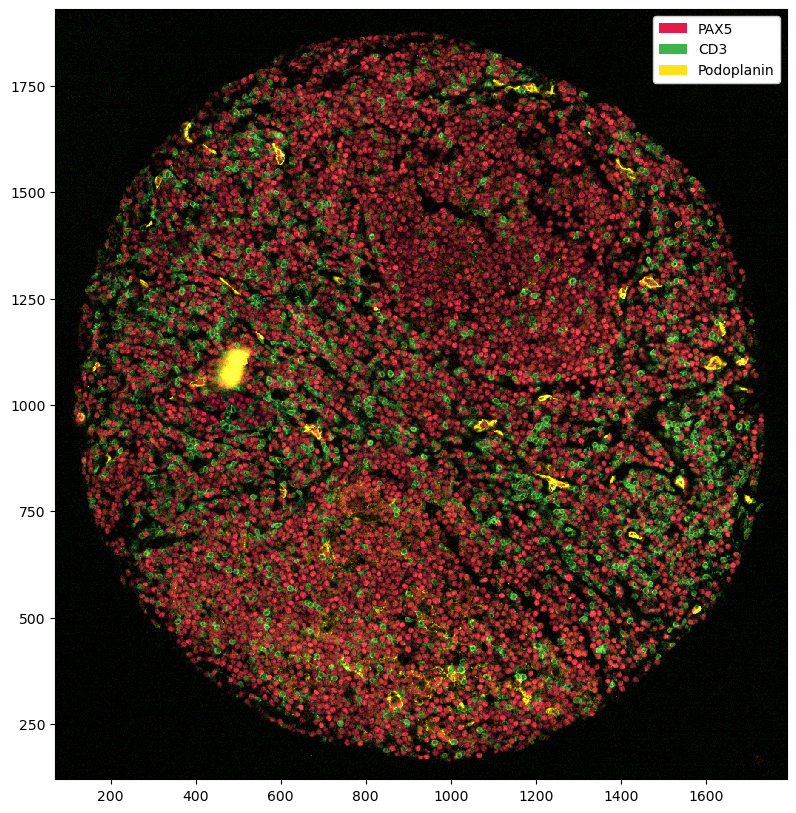

In [34]:
ds = xr.load_dataset('4_B4.zarr')

# quick plotting of some channels
plt.figure(figsize=(10, 10))
ds.pp[['PAX5', 'CD3', 'Podoplanin']].pl.autocrop().pl.show()

### Drawing in the healthy regions using TissueTag

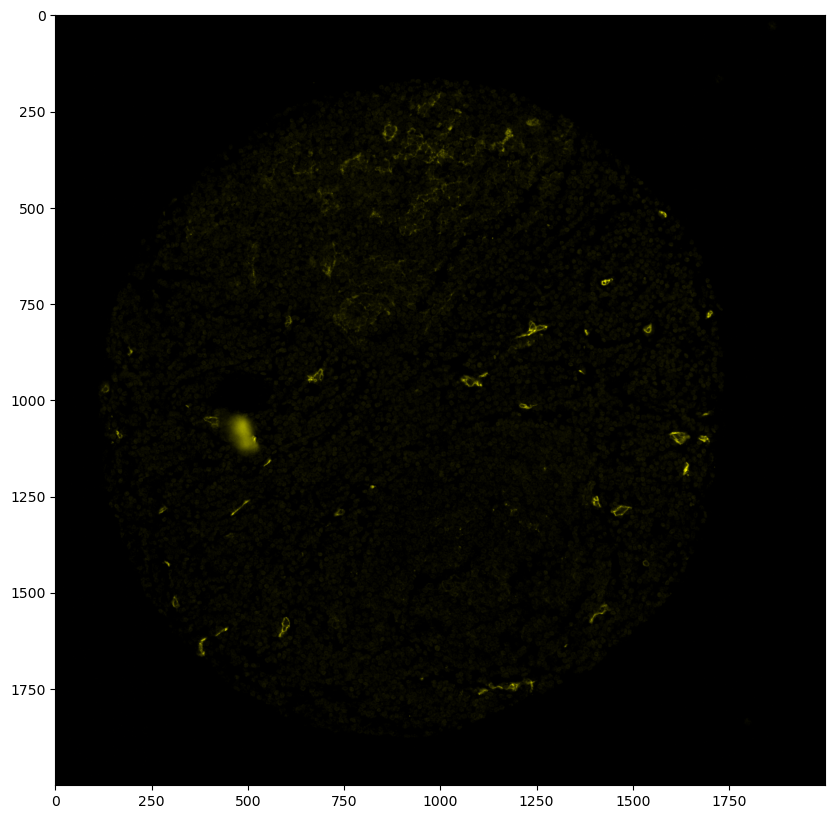

In [35]:
# first, we need to get our image as an RGBA image

# here, we extract the Podoplanin channel and assign it to the red and green channel, while keeping the blue channel at 0 and setting alpha to 1 everywhere
podoplanin_img = ds.pp['Podoplanin']['_image'].values[0]
# Create the RGBA image by stacking channels (R, G, B, A)
rgba_image = np.stack((podoplanin_img, podoplanin_img, np.zeros_like(podoplanin_img), np.ones_like(podoplanin_img) * 255), axis=-1)

plt.figure(figsize=(10, 10))
plt.imshow(rgba_image)

In [36]:
# next, we set up the annotation layer, which will ultimately become the binary mask that tells us where the tissue is
annodict = {'Artifact':'yellow'}
labels = np.zeros((rgba_image.shape[0], rgba_image.shape[1]), dtype=np.uint8)

In [37]:
# setup for TissueTag
import panel as pn
import socket
import os
import tissue_tag as tt

os.environ["BOKEH_ALLOW_WS_ORIGIN"] = "*"
host = '8888'

In [38]:
# use annotator to label tissue regions according to categories indicated above
annotator, render_dict = tt.annotator(rgba_image, labels, anno_dict=annodict, use_datashader=True)
pn.io.notebook.show_server(annotator, notebook_url=f'{socket.gethostname()}:{host}')

Starting Bokeh server version 3.4.3 (running on Tornado 6.4.1)
User authentication hooks NOT provided (default user enabled)


200 GET /autoload.js?bokeh-autoload-element=f1ca8cc2-1758-4c3d-a83c-757b15543c0d&bokeh-absolute-url=http://mac-huber33.local:53395&resources=none (::1) 189.82ms
INFO:tornado.access:200 GET /autoload.js?bokeh-autoload-element=f1ca8cc2-1758-4c3d-a83c-757b15543c0d&bokeh-absolute-url=http://mac-huber33.local:53395&resources=none (::1) 189.82ms
200 GET /static/js/bokeh.min.js?v=0a5da0be1c2385c8fbc778b6fe92af35da98e7b160ed40850e1b234b02df34a055ca50d37f82f056d346f1a6812c836eecbfb99371cfc264da60861011003592 (::1) 3.30ms
INFO:tornado.access:200 GET /static/js/bokeh.min.js?v=0a5da0be1c2385c8fbc778b6fe92af35da98e7b160ed40850e1b234b02df34a055ca50d37f82f056d346f1a6812c836eecbfb99371cfc264da60861011003592 (::1) 3.30ms
200 GET /static/js/bokeh-tables.min.js?v=30dd48a6c21439042b22c0586013c023610fdaba3c28ecd2549991ee689caaf69984c17f610f0259a9e7b9a0cec40dd018f52d36b47a6bd65e10d9885d3a861e (::1) 1.60ms
INFO:tornado.access:200 GET /static/js/bokeh-tables.min.js?v=30dd48a6c21439042b22c0586013c023610fdaba3c

Artifact


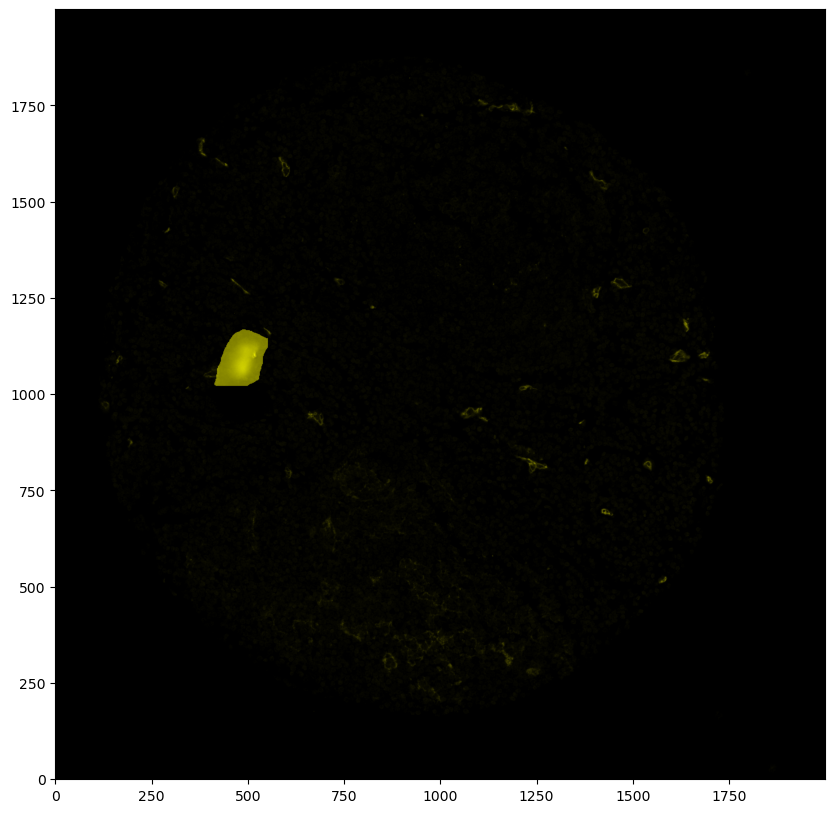

In [39]:
labels = tt.update_annotator(
    imarray=rgba_image,
    labels=labels,
    anno_dict=annodict,
    render_dict=render_dict
)

In [40]:
# inverting the labels so that 0 becomes 1 and 1 becomes 0
# the region where the artifact is should be 0, everything else should be 1
labels = 1 - labels

### Putting the mask into the spatialproteomics object

In [41]:
# by default, this method adds a layer with the key '_mask'
ds = ds.pp.add_layer(labels)

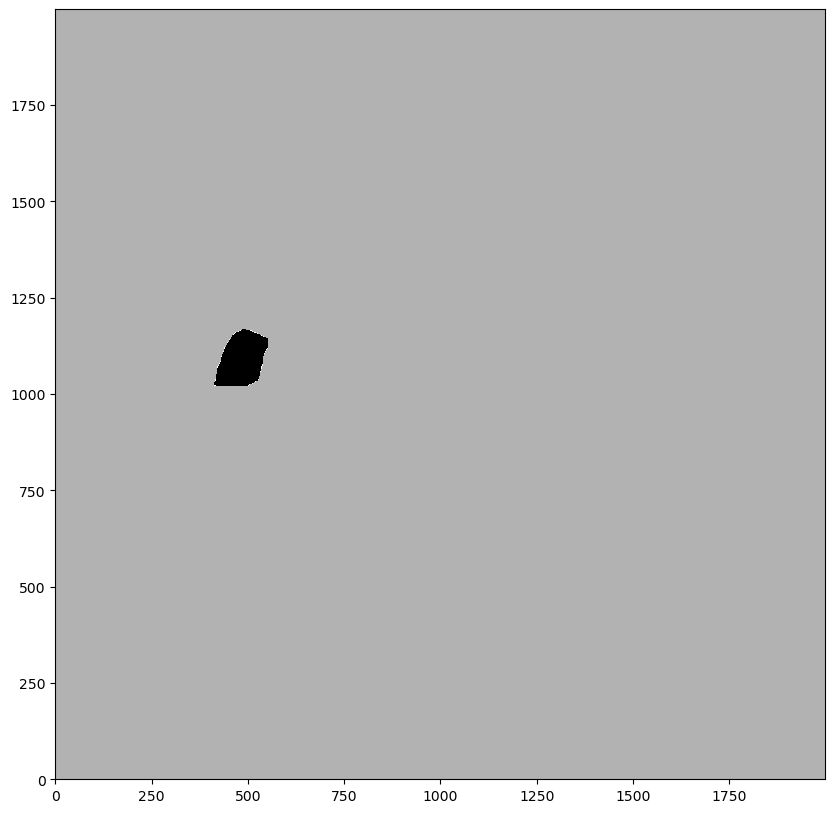

In [42]:
# plotting the mask (by using the render_segmentation method, since the data structure is conceptually similar to the segmentation)
_ = ds.pl.render_segmentation(layer_key='_mask', alpha=0.7).pl.imshow()

### Using the mask to set every pixel intensity to 0 in that region

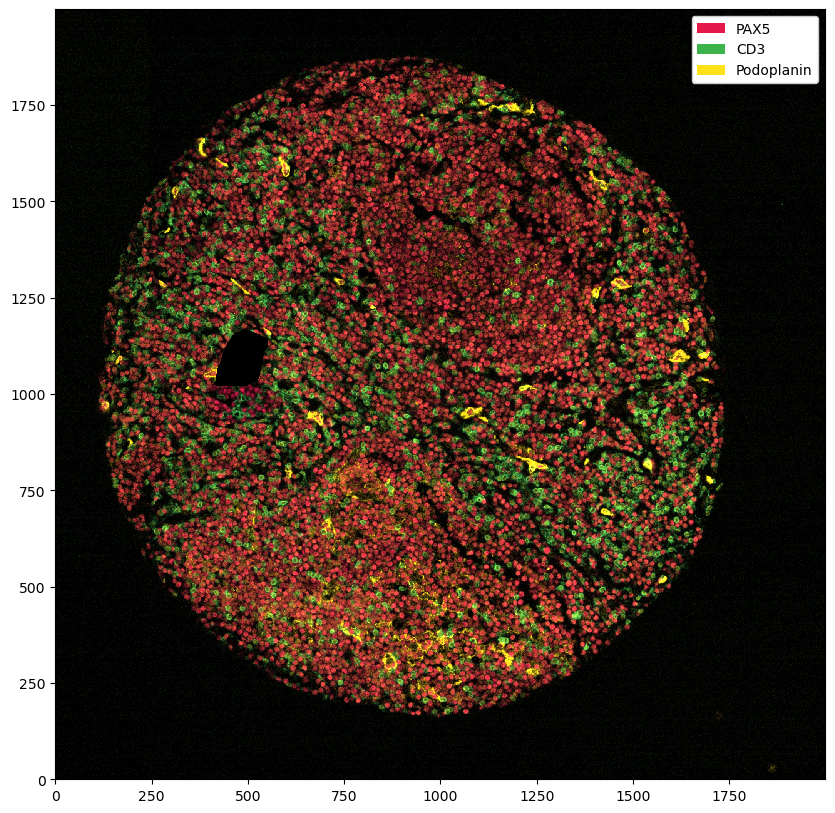

In [43]:
ds_masked_intensities = ds.pp.mask_region()
_ = ds_masked_intensities.pp[['PAX5', 'CD3', 'Podoplanin']].pl.show()

You can see that this set all of the marker intensities at 0 in the problematic region. However, if we plot the segmentation masks on top, you can see that we have not removed those.

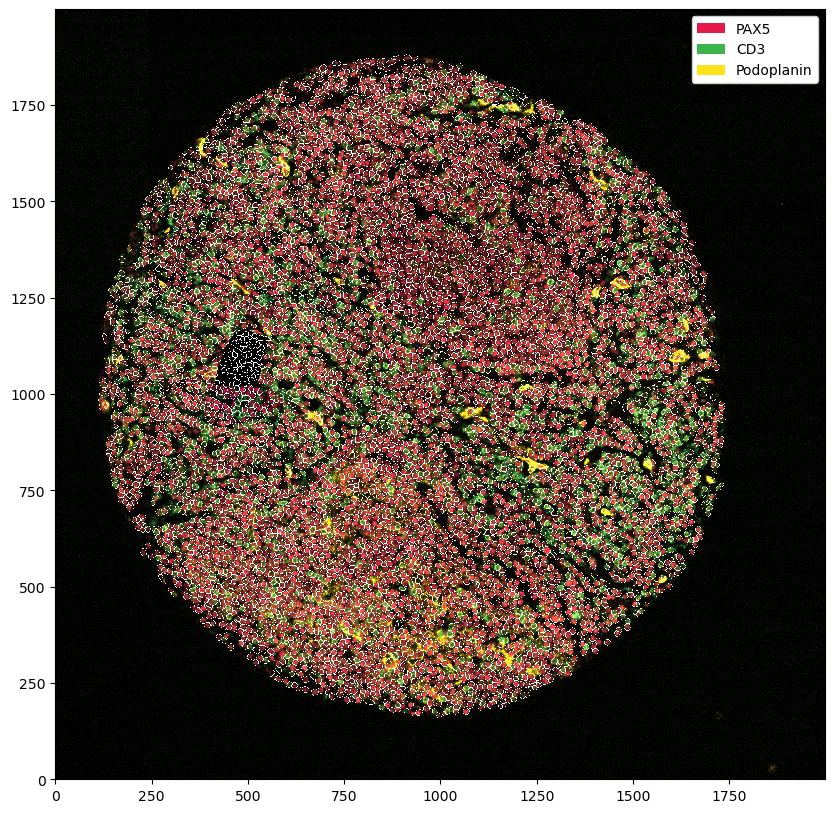

In [44]:
_ = ds_masked_intensities.pp[['PAX5', 'CD3', 'Podoplanin']].pl.show(render_segmentation=True)

Most of the time, what we want to do instead is to remove all cells that were segmented in the area. This way we still stick to the original data, but remove the problematic region from analysis.

### Using the mask to remove cells in that region

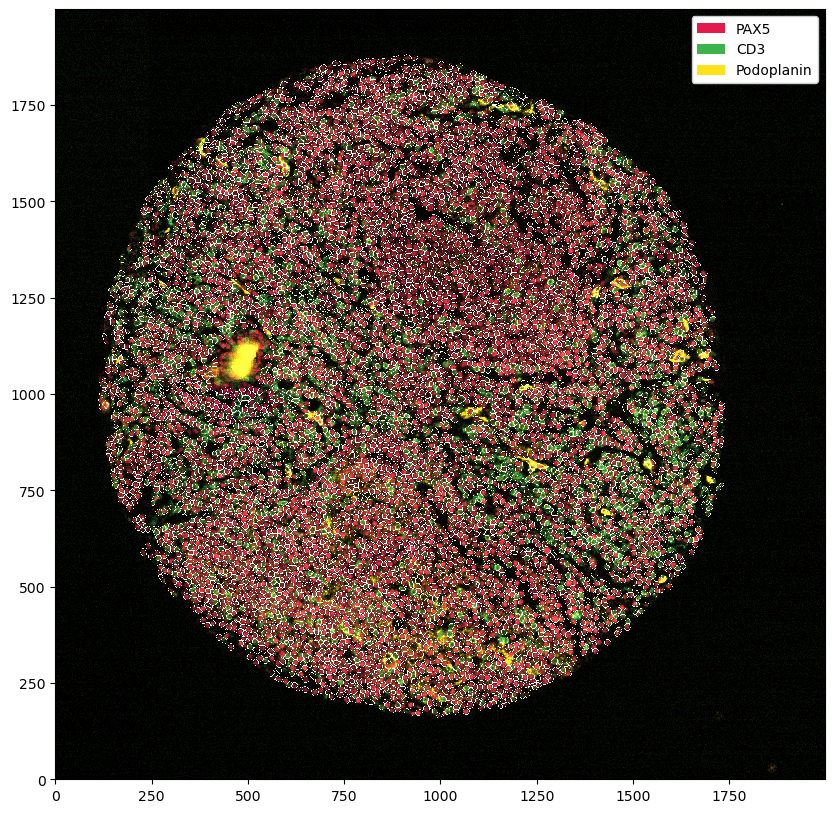

In [45]:
ds_masked_cells = ds.pp.mask_cells()
_ = ds_masked_cells.pp[['PAX5', 'CD3', 'Podoplanin']].pl.show(render_segmentation=True)

You can of course also combine the two.

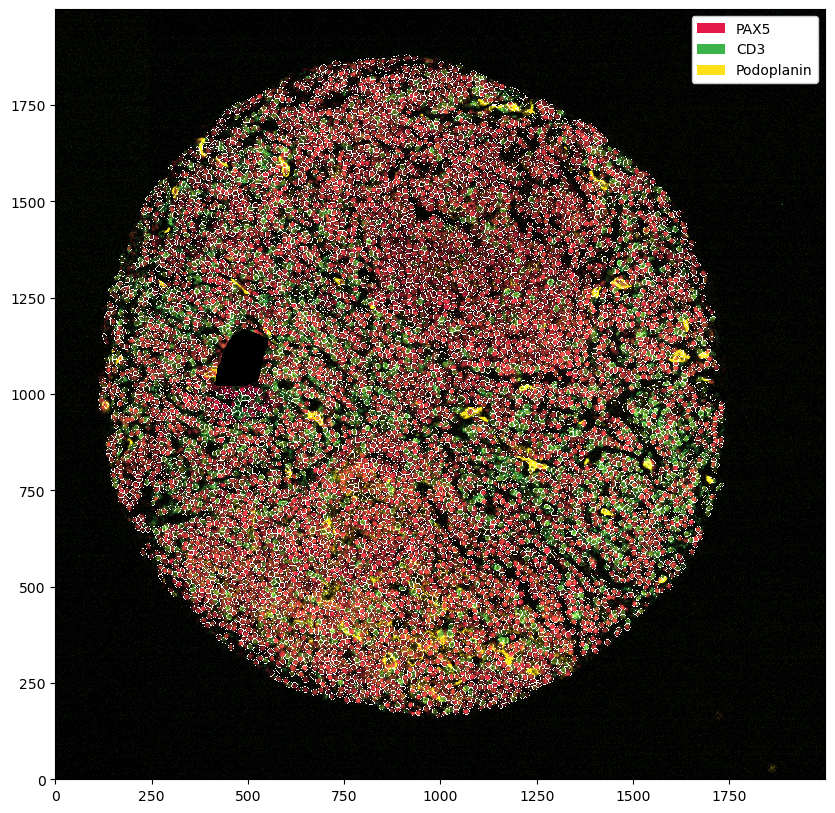

In [46]:
_ = ds.pp.mask_region().pp.mask_cells().pp[['PAX5', 'CD3', 'Podoplanin']].pl.show(render_segmentation=True)